10.4代码复盘任务：精简代码，多添加几个指标，把回归模型改为分类模型

11.2代码复盘：试一下三层神经网络运行一下模型，把回归改为分类，试一下有收盘价的回归

In [2]:
import pandas as pd
from pandas import read_csv
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
    )
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import os
import random
import time
import json
import itertools
import copy
import re

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 设置随机种子
set_seed(42)

In [4]:
print(f"CUDA是否可用? {torch.cuda.is_available()}")
print(f"当前CUDA 版本: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"当前CUDA ID:{torch.cuda.current_device()}")

print(f"CUDA设备名称:{torch.cuda.get_device_name(cuda_id)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')


CUDA是否可用? True
当前CUDA 版本: 12.4
当前CUDA ID:0
CUDA设备名称:NVIDIA GeForce RTX 3070 Laptop GPU
使用设备: cuda


In [5]:
class Args:
    def __init__(self):
        self.corpusFile = "D:/学习资料/25 04 神经网络模型对上证指数预测项目/上证指数数据获取/上证指数00-24.csv"  # 数据文件路径
        
        # 训练配置
        self.epochs = 250  # 训练轮数
        self.sequence_length = 5  # 时间序列长度
        self.batch_size = 64  # 批次大小
        self.batch_first = True  # 批次维度是否在第一维
        self.input_size = None  # 将在数据预处理后动态更新
        self.feature_count = None  # 记录可用特征数量
        
        # 学习率调度与早停
        self.patience = 10  # ReduceLROnPlateau 的耐心值
        self.gamma = 0.1  # 学习率衰减系数
        self.min_lr = 1e-6  # 最小学习率
        self.early_stopping_patience = 20  # 早停耐心值
        
        # 模型与数据持久化
        self.model_dir = './model'  # 统一模型目录
        self.model_file = 'stock.pkl'  # 模型文件名
        self.data_params_file = 'data_params.pth'  # 数据参数文件名
        self.save_file = f'{self.model_dir}/{self.model_file}'
        self.data_params_path = f'{self.model_dir}/{self.data_params_file}'
        
        # 默认超参数备份（超参搜索会覆盖这些值）
        self.default_hyperparams = {
            'num_layers': 2,
            'hidden_size': (64, 64),
            'dropout': 0.2,
            'lr': 0.001
        }
        
# 创建参数对象
args = Args()

print("参数配置:")
for key, value in vars(args).items():
    print(f"  {key}: {value}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')

参数配置:
  corpusFile: D:/学习资料/25 04 神经网络模型对上证指数预测项目/上证指数数据获取/上证指数00-24.csv
  epochs: 250
  sequence_length: 5
  batch_size: 64
  batch_first: True
  input_size: None
  feature_count: None
  patience: 10
  gamma: 0.1
  min_lr: 1e-06
  early_stopping_patience: 20
  model_dir: ./model
  model_file: stock.pkl
  data_params_file: data_params.pth
  save_file: ./model/stock.pkl
  data_params_path: ./model/data_params.pth
  default_hyperparams: {'num_layers': 2, 'hidden_size': (64, 64), 'dropout': 0.2, 'lr': 0.001}
使用设备: cuda


趋势指标：移动平均线；移动平均收敛散度； 动量指标：相对强弱指数；随机振荡指标； 波动率指标：布林带；平均真实波幅； 成交量指标：能量潮；成交量加权平均价

In [6]:
def add_sma(df):
    """
    向DataFrame中添加5日、20日、60日简单移动平均线(SMA)指标。

    参数:
    df (pd.DataFrame): 包含'close'列的股票数据DataFrame。

    返回:
    pd.DataFrame: 添加了SMA指标的新DataFrame。
    """
    df['SMA_5'] = df['close'].rolling(window=5).mean()
    df['SMA_20'] = df['close'].rolling(window=20).mean()
    df['SMA_60'] = df['close'].rolling(window=60).mean()
    return df

In [7]:
def add_macd(df, short_window=12, long_window=26, signal_window=9):
    """
    向DataFrame中添加移动平均收敛散度(MACD)指标。

    该函数会计算并添加三列：
    1. 'MACD': 短期EMA与长期EMA的差值。
    2. 'Signal_Line': MACD线的EMA。
    3. 'MACD_Hist': MACD线与信号线的差值。

    参数:
    df (pd.DataFrame): 必须包含'close'列的股票数据DataFrame。
    short_window (int): 短期EMA的窗口期，默认为12。
    long_window (int): 长期EMA的窗口期，默认为26。
    signal_window (int): 信号线的EMA窗口期，默认为9。

    返回:
    pd.DataFrame: 添加了MACD相关指标的新DataFrame。
    """
    # 1. 计算短期和长期指数移动平均线 (EMA)
    ema_short = df['close'].ewm(span=short_window, adjust=False).mean()
    ema_long = df['close'].ewm(span=long_window, adjust=False).mean()
    
    # 2. 计算MACD线
    df['MACD'] = ema_short - ema_long
    
    # 3. 计算信号线 (MACD线的9日EMA)
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    
    # 4. 计算MACD柱状图 (MACD线与信号线的差值)
    df['MACD_Hist'] = df['MACD'] - df['Signal_Line']
    
    return df

In [8]:
def add_rsi(df, window=14):
    """
    向DataFrame中添加相对强弱指数(RSI)指标。

    参数:
    df (pd.DataFrame): 必须包含'close'列的股票数据DataFrame。
    window (int): RSI的计算窗口期，默认为14。

    返回:
    pd.DataFrame: 添加了'RSI'列的新DataFrame。
    """
    # 1. 计算价格差异
    delta = df['close'].diff()

    # 2. 分离上涨和下跌
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    # 3. 计算相对强度 (RS)
    rs = gain / loss
    
    # 4. 计算RSI
    df['RSI'] = 100 - (100 / (1 + rs))
    
    return df

In [9]:
def add_stochastic(df, k_window=14, d_window=3):
    """
    向DataFrame中添加随机振荡指标 (%K 和 %D)。

    参数:
    df (pd.DataFrame): 必须包含 'high', 'low', 'close' 列。
    k_window (int): %K线的计算窗口期，默认为14。
    d_window (int): %D线的计算窗口期（%K的移动平均），默认为3。

    返回:
    pd.DataFrame: 添加了 'Stochastic_%K' 和 'Stochastic_%D' 列的新DataFrame。
    """
    # 计算窗口期内的最高价和最低价
    low_min = df['low'].rolling(window=k_window).min()
    high_max = df['high'].rolling(window=k_window).max()

    # 计算 %K
    df['Stochastic_%K'] = 100 * (df['close'] - low_min) / (high_max - low_min)
    
    # 计算 %D (%K的简单移动平均)
    df['Stochastic_%D'] = df['Stochastic_%K'].rolling(window=d_window).mean()
    
    return df

In [10]:
def add_bollinger_bands(df, window=20, num_std_dev=2):
    """
    向DataFrame中添加布林带指标。

    参数:
    df (pd.DataFrame): 必须包含 'close' 列。
    window (int): 移动平均线和标准差的计算窗口期，默认为20。
    num_std_dev (int): 标准差的倍数，默认为2。

    返回:
    pd.DataFrame: 添加了 'BB_Middle', 'BB_Upper', 'BB_Lower' 列的新DataFrame。
    """
    # 计算中间带 (20日SMA)
    df['BB_Middle'] = df['close'].rolling(window=window).mean()
    
    # 计算标准差
    std_dev = df['close'].rolling(window=window).std()
    
    # 计算上轨和下轨
    df['BB_Upper'] = df['BB_Middle'] + (std_dev * num_std_dev)
    df['BB_Lower'] = df['BB_Middle'] - (std_dev * num_std_dev)
    
    return df

In [11]:
def add_atr(df, window=14):
    """
    向DataFrame中添加平均真实波幅(ATR)指标。

    参数:
    df (pd.DataFrame): 必须包含 'high', 'low', 'close' 列。
    window (int): ATR的计算窗口期，默认为14。

    返回:
    pd.DataFrame: 添加了 'ATR' 列的新DataFrame。
    """
    # 计算 high-low, high-prev_close, low-prev_close
    high_low = df['high'] - df['low']
    high_prev_close = abs(df['high'] - df['close'].shift(1))
    low_prev_close = abs(df['low'] - df['close'].shift(1))
    
    # 计算真实波幅 (True Range)
    tr = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
    
    # 计算平均真实波幅 (ATR)，使用指数移动平均
    df['ATR'] = tr.ewm(alpha=1/window, adjust=False).mean()
    
    return df

In [12]:
def add_obv(df):
    """
    向DataFrame中添加能量潮(OBV)指标。

    参数:
    df (pd.DataFrame): 必须包含 'close' 和 'vol' 列。

    返回:
    pd.DataFrame: 添加了 'OBV' 列的新DataFrame。
    """
    # 计算价格变化方向
    price_change_direction = np.sign(df['close'].diff()).fillna(0)
    
    # 计算OBV（默认使用 'vol' 列）
    df['OBV'] = (price_change_direction * df['vol']).cumsum()
    
    return df

In [13]:
def add_rolling_vwap(df, window=14):
    """
    向DataFrame中添加滚动成交量加权平均价(VWAP)指标。

    参数:
    df (pd.DataFrame): 必须包含 'high', 'low', 'close' 和 'vol' 列。
    window (int): VWAP的滚动窗口期，默认为14。

    返回:
    pd.DataFrame: 添加了 'VWAP' 列的新DataFrame。
    """
    # 计算典型价格
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    
    # 计算滚动VWAP（默认使用 'vol' 列）
    tpv = (typical_price * df['vol']).rolling(window=window).sum()
    volume_sum = df['vol'].rolling(window=window).sum()
    
    df['VWAP'] = tpv / volume_sum
    
    return df

数据读取+预处理阶段

趋势指标：移动平均线；移动平均收敛散度； 动量指标：相对强弱指数；随机振荡指标； 波动率指标：布林带；平均真实波幅； 成交量指标：能量潮；成交量加权平均价

In [14]:
def load_and_process_data(corpusFile, config=None):
    """
    加载数据、添加技术指标并进行初步清洗，同时统计特征数量。
    """
    # 1. 数据读取
    stock_data = read_csv(corpusFile)
    
    # 2. 添加技术指标
    stock_data = add_sma(stock_data.copy())  # 添加简单移动平均线指标
    stock_data = add_macd(stock_data.copy())  # 添加MACD指标
    stock_data = add_rsi(stock_data.copy())  # 添加RSI指标
    stock_data = add_stochastic(stock_data.copy())  # 添加随机振荡指标
    stock_data = add_bollinger_bands(stock_data.copy())  # 添加布林带指标
    stock_data = add_atr(stock_data.copy())  # 添加平均真实波幅指标
    stock_data = add_obv(stock_data.copy())  # 添加能量潮指标
    stock_data = add_rolling_vwap(stock_data.copy())  # 添加成交量加权平均价
     
    # 3. 处理因计算指标产生的 NaN 值
    stock_data.dropna(inplace=True)
    stock_data.reset_index(drop=True, inplace=True)
    
    # 4. 删除不再需要的列
    columns_to_drop = ['ts_code', 'trade_date', 'pre_close', 'pct_chg']
    stock_data.drop(columns=[col for col in columns_to_drop if col in stock_data.columns], inplace=True)
    
    # pd.set_option('display.max_columns', None)  # 显示所有列
    # display(stock_data)
    
    # 5. 统计特征数量并同步到参数
    feature_columns = [col for col in stock_data.columns if col != 'close']
    feature_count = len(feature_columns)
    if config is not None:
        config.feature_count = feature_count
        config.input_size = feature_count
    
    return stock_data, feature_count

data, feature_count = load_and_process_data(args.corpusFile, args)
print(f"特征数量: {feature_count}")

特征数量: 21


In [15]:
def create_dataloaders(stock_data, sequence_length, batchSize):
    """
    将数据划分为训练/验证/测试集，进行归一化，并创建DataLoader。
    """
    if len(stock_data) <= sequence_length:
        raise ValueError(
            f"数据量 {len(stock_data)} 过小，无法按照序列长度 {sequence_length} 构建样本。"
        )
    
    cols = ['close'] + [col for col in stock_data.columns if col != 'close']
    stock_data = stock_data[cols]
    
    total_len = len(stock_data)
    train_size = int(0.6 * total_len)
    val_size = int(0.2 * total_len)
    
    train_df = stock_data.iloc[:train_size]
    val_df = stock_data.iloc[train_size: train_size + val_size]
    test_df = stock_data.iloc[train_size + val_size:]
    
    for split_name, df in {
        '训练集': train_df,
        '验证集': val_df,
        '测试集': test_df
    }.items():
        if len(df) <= sequence_length:
            raise ValueError(
                f"{split_name} 样本量 {len(df)} 小于或等于序列长度 {sequence_length}，"
                f"请减少 sequence_length 或调整数据划分比例。"
            )

    scaler = MinMaxScaler() # 1. 使用 MinMaxScaler 进行归一化
    # scaler = StandardScaler()  # 2. 使用 StandardScaler 进行标准化
    train_scaled = scaler.fit_transform(train_df)
    val_scaled = scaler.transform(val_df)
    test_scaled = scaler.transform(test_df)
    
    def create_sequences(data, sequence_length):
        X, Y = [], []
        # 特征数据不应包含目标列 'close'
        feature_data = data[:, 1:]
        target_data = data[:, 0]
        for i in range(len(data) - sequence_length):
            X.append(feature_data[i: i + sequence_length])
            Y.append(target_data[i + sequence_length])
        return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

    trainx, trainy = create_sequences(train_scaled, sequence_length)
    valx, valy = create_sequences(val_scaled, sequence_length)
    testx, testy = create_sequences(test_scaled, sequence_length)
    
    if trainx.size == 0 or valx.size == 0 or testx.size == 0:
        raise ValueError(
            "在构建时间序列样本时出现空数组，请检查数据长度和 sequence_length 设置。"
        )
    
    feature_dim = trainx.shape[2]
    print(f"\n总样本数: {len(stock_data)}")
    print(f"训练集大小: {len(trainx)}")
    print(f"验证集大小: {len(valx)}")
    print(f"测试集大小: {len(testx)}")
    print(f"特征数量: {feature_dim}")
    
    train_dataset = Mydataset(trainx, trainy)
    val_dataset = Mydataset(valx, valy)
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batchSize, shuffle=False)
    
    return train_loader, val_loader, scaler, testx, testy

class Mydataset(Dataset):
    def __init__(self, xx, yy):
        self.x = xx.astype(np.float32) if isinstance(xx, np.ndarray) else xx
        self.y = yy.astype(np.float32) if isinstance(yy, np.ndarray) else yy

    def __getitem__(self, index):
        x1 = torch.from_numpy(self.x[index]).float() if isinstance(self.x, np.ndarray) else self.x[index].float()
        y_raw = self.y[index] if isinstance(self.y, np.ndarray) else self.y[index]
        y1 = torch.tensor(y_raw, dtype=torch.float32) if not torch.is_tensor(y_raw) else y_raw.float()
        return x1, y1

    def __len__(self):
        return len(self.x)

模型构建

In [16]:
class lstm(nn.Module):  # 支持为每层设置不同的 hidden_size
    def __init__(self, input_size=8, hidden_size=32, num_layers=1, output_size=1, dropout=0, batch_first=True):
        super(lstm, self).__init__()
        if isinstance(hidden_size, int):
            hidden_sizes = [hidden_size] * num_layers
        else:
            hidden_sizes = list(hidden_size)
            if len(hidden_sizes) != num_layers:
                raise ValueError("hidden_size 序列的长度必须与 num_layers 相同")
        
        self.hidden_size = hidden_sizes[-1]  # 线性层输入维度取最后一层 hidden_size
        self.hidden_sizes = hidden_sizes
        self.input_size = input_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.dropout = dropout
        self.batch_first = batch_first
        
        self.lstm_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        
        in_size = self.input_size
        for layer_hidden in self.hidden_sizes:
            self.lstm_layers.append(
                nn.LSTM(
                    input_size=in_size,
                    hidden_size=layer_hidden,
                    num_layers=1,
                    batch_first=self.batch_first
                )
            )
            self.dropout_layers.append(nn.Dropout(self.dropout))
            in_size = layer_hidden
        
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x):
        out = x
        for i in range(self.num_layers):
            out, _ = self.lstm_layers[i](out)
            out = self.dropout_layers[i](out)
        
        last_output = out[:, -1, :]
        out = self.linear(last_output)
        return out

In [17]:
def _stack_batches(batches):
    if not batches:
        return torch.empty((0, 1), dtype=torch.float32)
    return torch.cat(batches, dim=0)

def train_one_epoch(model, dataloader, criterion, device, optimizer):
    model.train()
    total_loss = 0.0
    preds, labels = [], []

    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        if batch_x.dim() == 4 and batch_x.size(1) == 1:
            batch_x = batch_x.squeeze(1)
        if batch_y.dim() == 1:
            batch_y = batch_y.unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        preds.append(outputs.detach().cpu())
        labels.append(batch_y.detach().cpu())

    avg_loss = total_loss / max(len(dataloader), 1)
    return avg_loss, _stack_batches(preds), _stack_batches(labels)

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    preds, labels = [], []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            if batch_x.dim() == 4 and batch_x.size(1) == 1:
                batch_x = batch_x.squeeze(1)
            if batch_y.dim() == 1:
                batch_y = batch_y.unsqueeze(1)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()

            preds.append(outputs.detach().cpu())
            labels.append(batch_y.detach().cpu())

    avg_loss = total_loss / max(len(dataloader), 1)
    return avg_loss, _stack_batches(preds), _stack_batches(labels)

In [18]:
def train(current_args, metric_fns=None):
    set_seed(42)
    
    stock_data, feature_count = load_and_process_data(current_args.corpusFile, current_args)
    train_loader, val_loader, scaler, testx, testy = create_dataloaders(
        stock_data,
        current_args.sequence_length,
        current_args.batch_size)
    
    # 再次确认特征维度与数据一致
    if testx.size > 0:
        derived_feature_dim = testx.shape[2]
        if derived_feature_dim != feature_count:
            feature_count = derived_feature_dim
    current_args.feature_count = feature_count
    current_args.input_size = feature_count
    
    defaults = getattr(current_args, "default_hyperparams", {})
    hidden_size = getattr(current_args, "hidden_size", defaults.get("hidden_size"))
    num_layers = getattr(current_args, "num_layers", defaults.get("num_layers"))
    dropout = getattr(current_args, "dropout", defaults.get("dropout"))
    learning_rate = getattr(current_args, "lr", defaults.get("lr"))
    
    if hidden_size is None or num_layers is None or dropout is None or learning_rate is None:
        raise ValueError("current_args 缺少必要的超参数配置，请确保已通过超参搜索或提供默认值。")
    
    model = lstm(
        input_size=current_args.input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=1,
        dropout=dropout,
        batch_first=current_args.batch_first)
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        patience=current_args.patience,
        factor=current_args.gamma,
        min_lr=current_args.min_lr,
        verbose=False)
    
    history = {"train_loss": [], "val_loss": [], "metrics": []}
    best_snapshot = {"loss": float("inf"), "epoch": 0}
    no_improvement = 0
    
    for epoch in range(1, current_args.epochs + 1):
        train_loss, train_preds, train_labels = train_one_epoch(
            model, train_loader, criterion, device, optimizer)
        
        val_loss, val_preds, val_labels = validate_one_epoch(
            model, val_loader, criterion, device)
        
        scheduler.step(val_loss)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        
        metrics = {}
        if metric_fns and val_labels.numel() > 0:
            val_labels_np = val_labels.numpy()
            val_preds_np = val_preds.numpy()
            for name, fn in metric_fns.items():
                metrics[name] = fn(val_labels_np, val_preds_np)
        history["metrics"].append(metrics)
        
        if val_loss < best_snapshot["loss"]:
            best_snapshot.update({"loss": val_loss, "epoch": epoch})
            os.makedirs(os.path.dirname(current_args.save_file), exist_ok=True)
            torch.save(model.state_dict(), current_args.save_file)
            
            data_payload = {
                "scaler": scaler,
                "testx": testx,
                "testy": testy,
                "feature_count": current_args.feature_count
            }
            data_params_path = getattr(current_args, "data_params_path", current_args.data_params_file)
            torch.save(data_payload, data_params_path)
            
            manifest = {
                "model_path": current_args.save_file,
                "data_params_path": data_params_path,
                "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
            }
            manifest_path = os.path.join(current_args.model_dir, "best_paths.json")
            with open(manifest_path, "w", encoding="utf-8") as fh:
                json.dump(manifest, fh, ensure_ascii=False, indent=2)
            
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= current_args.early_stopping_patience:
                break
    
    return best_snapshot["loss"], history, best_snapshot["epoch"]

In [19]:
hidden_size_map = {
    1: [(32,), (64,), (128,), (256,)],
    2: [(32, 64), (32, 128), (32, 256), (64, 128), (64, 256), (128, 256)]
}

base_param_grid = {
    'num_layers': [1, 2],
    'dropout': [0.1, 0.2, 0.3],
    'lr': [0.01, 0.001],
    'batch_size': [64, 128, 256]
}

def expand_grid(grid_dict):
    keys = list(grid_dict.keys())
    for values in itertools.product(*(grid_dict[key] for key in keys)):
        yield dict(zip(keys, values))

def build_param_combinations():
    combinations = []
    for num_layers in base_param_grid['num_layers']:
        grid = {
            'num_layers': [num_layers],
            'hidden_size': hidden_size_map[num_layers],
            'dropout': base_param_grid['dropout'],
            'lr': base_param_grid['lr'],
            'batch_size': base_param_grid['batch_size']
        }
        combinations.extend(expand_grid(grid))
    return combinations

param_combinations = build_param_combinations()

print(f"开始超参数搜索，总共 {len(param_combinations)} 种组合...\n")

开始超参数搜索，总共 180 种组合...



In [19]:
best_loss = float('inf')
best_params = {}
best_model_path = ''
best_data_path = ''
best_train_losses = []
best_val_losses = []
best_final_epoch = 0
best_history = None

for idx, params in enumerate(param_combinations, start=1):
    print(f"--- [{idx}/{len(param_combinations)}] 正在尝试组合: {params} ---")
    
    current_args = copy.deepcopy(args)
    current_args.num_layers = params['num_layers']
    current_args.hidden_size = params['hidden_size']
    current_args.dropout = params['dropout']
    current_args.lr = params['lr']
    current_args.batch_size = params['batch_size']
    
    hidden_tag = '-'.join(map(str, params['hidden_size']))
    
    current_args.save_file = os.path.join(
        current_args.model_dir,
        f"stock_hs{hidden_tag}_nl{params['num_layers']}_do{str(params['dropout']).replace('.', '')}_lr{params['lr']}_bs{params['batch_size']}.pkl"
    )
    
    current_args.data_params_path = os.path.join(
        current_args.model_dir,
        f"data_params_hs{hidden_tag}_nl{params['num_layers']}_do{str(params['dropout']).replace('.', '')}_lr{params['lr']}_bs{params['batch_size']}.pth"
    )

    val_loss, history, final_epoch = train(current_args)
    print(f"↳ 完成。验证损失: {val_loss:.6f} (在 {final_epoch} 个 epoch 后停止)")

    if val_loss < best_loss:
        best_loss = val_loss
        best_params = params.copy()
        best_model_path = current_args.save_file
        best_data_path = current_args.data_params_path
        best_final_epoch = final_epoch
        best_history = copy.deepcopy(history)
        best_train_losses = best_history.get('train_loss', [])
        best_val_losses = best_history.get('val_loss', [])
        print(f"✨ 新的最佳组合！损失: {best_loss:.6f}\n")

print("\n==========================================")
print("超参数搜索完成！")
print(f"最佳验证损失: {best_loss:.6f}")
print(f"最佳超参数: {best_params}")
print(f"最佳模型保存在: {best_model_path}")
print(f"最佳数据参数保存在: {best_data_path}")
print("==========================================")

if best_model_path and best_data_path:
    manifest_payload = {
        "model_path": os.path.abspath(best_model_path),
        "data_params_path": os.path.abspath(best_data_path),
        "best_loss": float(best_loss),
        "best_params": {
            "num_layers": best_params.get('num_layers'),
            "hidden_size": (
                list(best_params['hidden_size'])
                if isinstance(best_params.get('hidden_size'), (list, tuple))
                else best_params.get('hidden_size')
            ),
            "dropout": best_params.get('dropout'),
            "lr": best_params.get('lr'),
            "batch_size": best_params.get('batch_size')
        },
        "final_epoch": int(best_final_epoch),
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
    }
    manifest_path = os.path.join(getattr(args, 'model_dir', 'model'), 'best_paths.json')
    os.makedirs(os.path.dirname(manifest_path), exist_ok=True)
    with open(manifest_path, 'w', encoding='utf-8') as fh:
        json.dump(manifest_payload, fh, ensure_ascii=False, indent=2)
    print(f"已更新最佳模型清单: {os.path.abspath(manifest_path)}")
else:
    print("⚠️ 未能更新最佳模型清单，请检查训练是否成功并生成模型。")

--- [1/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (32,), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000405 (在 18 个 epoch 后停止)
✨ 新的最佳组合！损失: 0.000405

--- [2/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (32,), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000995 (在 5 个 epoch 后停止)
--- [3/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (32,), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000728 (在 14 个 epoch 后停止)
--- [4/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (32,), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000686 (在 57 个 epoch 后停止)
--- [5/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (32,), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001961 (在 50 个 epoch 后停止)
--- [6/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (32,), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.003000 (在 40 个 epoch 后停止)
--- [7/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (32,), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000484 (在 26 个 epoch 后停止)
--- [8/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (32,), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000604 (在 32 个 epoch 后停止)
--- [9/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (32,), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001231 (在 9 个 epoch 后停止)
--- [10/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (32,), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.002581 (在 13 个 epoch 后停止)
--- [11/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (32,), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.003168 (在 18 个 epoch 后停止)
--- [12/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (32,), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.003296 (在 40 个 epoch 后停止)
--- [13/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (32,), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000372 (在 26 个 epoch 后停止)
✨ 新的最佳组合！损失: 0.000372

--- [14/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (32,), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001386 (在 4 个 epoch 后停止)
--- [15/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (32,), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001522 (在 9 个 epoch 后停止)
--- [16/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (32,), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.002996 (在 13 个 epoch 后停止)
--- [17/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (32,), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001437 (在 90 个 epoch 后停止)
--- [18/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (32,), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.003664 (在 61 个 epoch 后停止)
--- [19/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (64,), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000037 (在 49 个 epoch 后停止)
✨ 新的最佳组合！损失: 0.000037

--- [20/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (64,), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000053 (在 55 个 epoch 后停止)
--- [21/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (64,), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000103 (在 90 个 epoch 后停止)
--- [22/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (64,), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000124 (在 73 个 epoch 后停止)
--- [23/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (64,), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000379 (在 75 个 epoch 后停止)
--- [24/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (64,), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000758 (在 109 个 epoch 后停止)
--- [25/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (64,), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000070 (在 39 个 epoch 后停止)
--- [26/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (64,), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000155 (在 26 个 epoch 后停止)
--- [27/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (64,), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000222 (在 29 个 epoch 后停止)
--- [28/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (64,), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000463 (在 73 个 epoch 后停止)
--- [29/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (64,), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001337 (在 59 个 epoch 后停止)
--- [30/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (64,), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000714 (在 116 个 epoch 后停止)
--- [31/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (64,), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000127 (在 22 个 epoch 后停止)
--- [32/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (64,), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000228 (在 21 个 epoch 后停止)
--- [33/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (64,), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000360 (在 18 个 epoch 后停止)
--- [34/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (64,), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000715 (在 49 个 epoch 后停止)
--- [35/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (64,), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000673 (在 74 个 epoch 后停止)
--- [36/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (64,), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000755 (在 133 个 epoch 后停止)
--- [37/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (128,), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000026 (在 33 个 epoch 后停止)
✨ 新的最佳组合！损失: 0.000026

--- [38/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (128,), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000019 (在 107 个 epoch 后停止)
✨ 新的最佳组合！损失: 0.000019

--- [39/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (128,), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000115 (在 31 个 epoch 后停止)
--- [40/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (128,), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000034 (在 60 个 epoch 后停止)
--- [41/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (128,), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000041 (在 98 个 epoch 后停止)
--- [42/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (128,), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000307 (在 88 个 epoch 后停止)
--- [43/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (128,), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000023 (在 106 个 epoch 后停止)
--- [44/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (128,), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000049 (在 42 个 epoch 后停止)
--- [45/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (128,), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000075 (在 71 个 epoch 后停止)
--- [46/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (128,), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000074 (在 56 个 epoch 后停止)
--- [47/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (128,), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000111 (在 69 个 epoch 后停止)
--- [48/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (128,), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000534 (在 30 个 epoch 后停止)
--- [49/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (128,), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000034 (在 55 个 epoch 后停止)
--- [50/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (128,), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000051 (在 36 个 epoch 后停止)
--- [51/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (128,), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000168 (在 32 个 epoch 后停止)
--- [52/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (128,), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000104 (在 52 个 epoch 后停止)
--- [53/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (128,), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000215 (在 49 个 epoch 后停止)
--- [54/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (128,), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000410 (在 44 个 epoch 后停止)
--- [55/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (256,), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000045 (在 33 个 epoch 后停止)
--- [56/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (256,), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000031 (在 62 个 epoch 后停止)
--- [57/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (256,), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000150 (在 40 个 epoch 后停止)
--- [58/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (256,), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000031 (在 53 个 epoch 后停止)
--- [59/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (256,), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000024 (在 95 个 epoch 后停止)
--- [60/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (256,), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000052 (在 126 个 epoch 后停止)
--- [61/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (256,), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000075 (在 54 个 epoch 后停止)
--- [62/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (256,), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000066 (在 65 个 epoch 后停止)
--- [63/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (256,), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000089 (在 89 个 epoch 后停止)
--- [64/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (256,), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000018 (在 93 个 epoch 后停止)
✨ 新的最佳组合！损失: 0.000018

--- [65/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (256,), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000028 (在 112 个 epoch 后停止)
--- [66/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (256,), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000047 (在 118 个 epoch 后停止)
--- [67/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (256,), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000049 (在 67 个 epoch 后停止)
--- [68/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (256,), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000134 (在 32 个 epoch 后停止)
--- [69/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (256,), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000201 (在 36 个 epoch 后停止)
--- [70/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (256,), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000024 (在 96 个 epoch 后停止)
--- [71/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (256,), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000038 (在 96 个 epoch 后停止)
--- [72/180] 正在尝试组合: {'num_layers': 1, 'hidden_size': (256,), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000075 (在 113 个 epoch 后停止)
--- [73/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 64), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000778 (在 11 个 epoch 后停止)
--- [74/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 64), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000857 (在 15 个 epoch 后停止)
--- [75/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 64), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000580 (在 33 个 epoch 后停止)
--- [76/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 64), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000404 (在 62 个 epoch 后停止)
--- [77/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 64), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000622 (在 92 个 epoch 后停止)
--- [78/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 64), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000888 (在 102 个 epoch 后停止)
--- [79/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 64), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001606 (在 11 个 epoch 后停止)
--- [80/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 64), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001357 (在 12 个 epoch 后停止)
--- [81/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 64), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000781 (在 30 个 epoch 后停止)
--- [82/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 64), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000634 (在 62 个 epoch 后停止)
--- [83/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 64), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001643 (在 49 个 epoch 后停止)
--- [84/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 64), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.003363 (在 51 个 epoch 后停止)
--- [85/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 64), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.003051 (在 3 个 epoch 后停止)
--- [86/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 64), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.002258 (在 12 个 epoch 后停止)
--- [87/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 64), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001776 (在 25 个 epoch 后停止)
--- [88/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 64), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000703 (在 86 个 epoch 后停止)
--- [89/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 64), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.002146 (在 38 个 epoch 后停止)
--- [90/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 64), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.003958 (在 51 个 epoch 后停止)
--- [91/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 128), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000929 (在 14 个 epoch 后停止)
--- [92/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 128), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000603 (在 19 个 epoch 后停止)
--- [93/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 128), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000897 (在 44 个 epoch 后停止)
--- [94/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 128), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000817 (在 31 个 epoch 后停止)
--- [95/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 128), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001393 (在 74 个 epoch 后停止)
--- [96/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 128), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.002442 (在 23 个 epoch 后停止)
--- [97/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 128), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001333 (在 8 个 epoch 后停止)
--- [98/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 128), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.002140 (在 12 个 epoch 后停止)
--- [99/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 128), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001456 (在 26 个 epoch 后停止)
--- [100/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 128), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001085 (在 27 个 epoch 后停止)
--- [101/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 128), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001290 (在 44 个 epoch 后停止)
--- [102/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 128), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001707 (在 59 个 epoch 后停止)
--- [103/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 128), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.003044 (在 5 个 epoch 后停止)
--- [104/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 128), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.003323 (在 11 个 epoch 后停止)
--- [105/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 128), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.002221 (在 18 个 epoch 后停止)
--- [106/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 128), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001324 (在 27 个 epoch 后停止)
--- [107/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 128), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001376 (在 51 个 epoch 后停止)
--- [108/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 128), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.002673 (在 31 个 epoch 后停止)
--- [109/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 256), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000096 (在 27 个 epoch 后停止)
--- [110/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 256), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000372 (在 30 个 epoch 后停止)
--- [111/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 256), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000602 (在 31 个 epoch 后停止)
--- [112/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 256), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000386 (在 32 个 epoch 后停止)
--- [113/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 256), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000643 (在 42 个 epoch 后停止)
--- [114/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 256), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001060 (在 47 个 epoch 后停止)
--- [115/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 256), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000323 (在 16 个 epoch 后停止)
--- [116/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 256), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000604 (在 25 个 epoch 后停止)
--- [117/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 256), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000778 (在 38 个 epoch 后停止)
--- [118/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 256), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000484 (在 32 个 epoch 后停止)
--- [119/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 256), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000965 (在 69 个 epoch 后停止)
--- [120/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 256), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001551 (在 30 个 epoch 后停止)
--- [121/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 256), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000898 (在 5 个 epoch 后停止)
--- [122/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 256), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000542 (在 13 个 epoch 后停止)
--- [123/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 256), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000411 (在 38 个 epoch 后停止)
--- [124/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 256), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001258 (在 29 个 epoch 后停止)
--- [125/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 256), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001282 (在 31 个 epoch 后停止)
--- [126/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (32, 256), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001710 (在 32 个 epoch 后停止)
--- [127/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 128), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000320 (在 9 个 epoch 后停止)
--- [128/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 128), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000154 (在 26 个 epoch 后停止)
--- [129/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 128), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000719 (在 12 个 epoch 后停止)
--- [130/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 128), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000075 (在 69 个 epoch 后停止)
--- [131/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 128), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000321 (在 52 个 epoch 后停止)
--- [132/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 128), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001408 (在 31 个 epoch 后停止)
--- [133/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 128), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000339 (在 6 个 epoch 后停止)
--- [134/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 128), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000849 (在 10 个 epoch 后停止)
--- [135/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 128), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000315 (在 33 个 epoch 后停止)
--- [136/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 128), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000171 (在 55 个 epoch 后停止)
--- [137/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 128), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000310 (在 70 个 epoch 后停止)
--- [138/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 128), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001212 (在 71 个 epoch 后停止)
--- [139/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 128), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001011 (在 6 个 epoch 后停止)
--- [140/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 128), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001161 (在 5 个 epoch 后停止)
--- [141/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 128), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001318 (在 10 个 epoch 后停止)
--- [142/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 128), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000573 (在 34 个 epoch 后停止)
--- [143/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 128), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000908 (在 41 个 epoch 后停止)
--- [144/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 128), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001812 (在 31 个 epoch 后停止)
--- [145/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 256), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000255 (在 38 个 epoch 后停止)
--- [146/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 256), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000367 (在 25 个 epoch 后停止)
--- [147/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 256), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000252 (在 100 个 epoch 后停止)
--- [148/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 256), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000100 (在 60 个 epoch 后停止)
--- [149/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 256), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000087 (在 71 个 epoch 后停止)
--- [150/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 256), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000677 (在 66 个 epoch 后停止)
--- [151/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 256), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000265 (在 43 个 epoch 后停止)
--- [152/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 256), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000424 (在 25 个 epoch 后停止)
--- [153/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 256), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000226 (在 91 个 epoch 后停止)
--- [154/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 256), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000108 (在 45 个 epoch 后停止)
--- [155/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 256), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000201 (在 73 个 epoch 后停止)
--- [156/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 256), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000863 (在 50 个 epoch 后停止)
--- [157/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 256), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000622 (在 12 个 epoch 后停止)
--- [158/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 256), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000420 (在 25 个 epoch 后停止)
--- [159/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 256), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000420 (在 24 个 epoch 后停止)
--- [160/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 256), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000179 (在 47 个 epoch 后停止)
--- [161/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 256), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000909 (在 19 个 epoch 后停止)
--- [162/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (64, 256), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.001221 (在 27 个 epoch 后停止)
--- [163/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (128, 256), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000108 (在 23 个 epoch 后停止)
--- [164/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (128, 256), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000222 (在 11 个 epoch 后停止)
--- [165/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (128, 256), 'dropout': 0.1, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000109 (在 66 个 epoch 后停止)
--- [166/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (128, 256), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000025 (在 58 个 epoch 后停止)
--- [167/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (128, 256), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000048 (在 61 个 epoch 后停止)
--- [168/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (128, 256), 'dropout': 0.1, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000071 (在 82 个 epoch 后停止)
--- [169/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (128, 256), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000172 (在 9 个 epoch 后停止)
--- [170/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (128, 256), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000191 (在 16 个 epoch 后停止)
--- [171/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (128, 256), 'dropout': 0.2, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000245 (在 23 个 epoch 后停止)
--- [172/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (128, 256), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000038 (在 58 个 epoch 后停止)
--- [173/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (128, 256), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000083 (在 69 个 epoch 后停止)
--- [174/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (128, 256), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000225 (在 62 个 epoch 后停止)
--- [175/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (128, 256), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000303 (在 9 个 epoch 后停止)
--- [176/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (128, 256), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000231 (在 17 个 epoch 后停止)
--- [177/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (128, 256), 'dropout': 0.3, 'lr': 0.01, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000313 (在 23 个 epoch 后停止)
--- [178/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (128, 256), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000089 (在 33 个 epoch 后停止)
--- [179/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (128, 256), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 128} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000170 (在 65 个 epoch 后停止)
--- [180/180] 正在尝试组合: {'num_layers': 2, 'hidden_size': (128, 256), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 256} ---

总样本数: 5999
训练集大小: 3594
验证集大小: 1194
测试集大小: 1196
特征数量: 21


d:\Anaconda\envs\dpln311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


↳ 完成。验证损失: 0.000520 (在 25 个 epoch 后停止)

超参数搜索完成！
最佳验证损失: 0.000018
最佳超参数: {'num_layers': 1, 'hidden_size': (256,), 'dropout': 0.2, 'lr': 0.001, 'batch_size': 64}
最佳模型保存在: ./model\stock_hs256_nl1_do02_lr0.001_bs64.pkl
最佳数据参数保存在: ./model\data_params_hs256_nl1_do02_lr0.001_bs64.pth
已更新最佳模型清单: d:\学习资料\25 04 神经网络模型对上证指数预测项目\lstm_torch_ver2\model\best_paths.json


已添加 2 个待办事项

正在启动(1/3) *设计多模型保存方案*

已完成(1/3) *设计多模型保存方案*

正在启动(2/3) *规划清单文件结构调整*

已完成(2/3) *规划清单文件结构调整*

验证模型

In [23]:
def infer_hyperparams_from_model_path(model_path):
    pattern = (
        r"stock_hs(?P<hs>[\d\-]+)_nl(?P<nl>\d+)_do(?P<do>\d+)_"
        r"lr(?P<lr>0\.\d+)_bs(?P<bs>\d+)\.pkl"
    )
    match = re.search(pattern, os.path.basename(model_path))
    if not match:
        raise ValueError(
            f"无法从模型文件名 `{os.path.basename(model_path)}` 推断超参数，请确认命名约定一致。"
        )
    hs_token = match.group('hs')
    num_layers = int(match.group('nl'))
    dropout_token = match.group('do')
    learning_rate = float(match.group('lr'))
    batch_size = int(match.group('bs'))
    hidden_sizes = tuple(int(x) for x in hs_token.split('-'))
    if len(hidden_sizes) == 1:
        hidden_sizes = hidden_sizes[0] if num_layers == 1 else hidden_sizes * num_layers
    elif len(hidden_sizes) != num_layers:
        raise ValueError(
            f"隐藏层配置 `{hidden_sizes}` 与层数 `{num_layers}` 不匹配，请检查模型文件名。"
        )
    dropout = int(dropout_token) / 10 if dropout_token.isdigit() else float(dropout_token)
    return {
        'hidden_size': hidden_sizes,
        'num_layers': num_layers,
        'dropout': dropout,
        'lr': learning_rate,
        'batch_size': batch_size
    }

In [21]:
def eval(model_path, data_params_path):
    defaults = getattr(args, 'default_hyperparams', {})
    
    resolved = {
        'hidden_size': defaults.get('hidden_size'),
        'num_layers': defaults.get('num_layers'),
        'dropout': defaults.get('dropout'),
        'lr': defaults.get('lr'),
        'batch_size': defaults.get('batch_size', args.batch_size)
    }
    inferred = infer_hyperparams_from_model_path(model_path)
    resolved.update({k: v for k, v in inferred.items() if v is not None})
    
    if best_params:
        conflicts = []
        for key, value in best_params.items():
            if value is None:
                continue
            if key not in inferred:
                resolved[key] = value
                continue
            inferred_value = inferred[key]
            if key == 'hidden_size':
                value_norm = tuple(value) if isinstance(value, (list, tuple)) else (value,)
                inferred_norm = tuple(inferred_value) if isinstance(inferred_value, (list, tuple)) else (inferred_value,)
                if value_norm != inferred_norm:
                    conflicts.append(key)
                    continue
            elif key == 'dropout':
                if not np.isclose(value, inferred_value):
                    conflicts.append(key)
                    continue
            else:
                if value != inferred_value:
                    conflicts.append(key)
                    continue
            resolved[key] = value
        if conflicts:
            print(f"警告: best_params 与模型文件推断的超参数在 {conflicts} 上不一致，已以模型文件命名为准。")
            
    best_hidden_size = resolved['hidden_size']
    best_num_layers = resolved['num_layers']
    best_dropout = resolved['dropout']
    best_lr = resolved['lr']
    best_batch_size = resolved['batch_size']
    
    if best_hidden_size is None or best_num_layers is None or best_dropout is None or best_lr is None:
        raise ValueError('缺少必要的超参数信息，无法进行模型评估。请确认 best_params 或模型文件名解析是否成功。')
    
    data_params = torch.load(data_params_path, map_location='cpu')
    scaler = data_params['scaler']
    testx = data_params['testx']
    testy = data_params['testy']
    feature_count = data_params.get('feature_count')
    
    if feature_count is None and hasattr(testx, 'shape') and testx.size > 0:
        feature_count = testx.shape[2]
        
    if feature_count is None:
        raise ValueError('无法从保存的数据中推断特征数量。')
    
    args.feature_count = feature_count
    args.input_size = feature_count
    
    model = lstm(
        input_size=feature_count,
        hidden_size=best_hidden_size,
        num_layers=best_num_layers,
        dropout=best_dropout,
        batch_first=True,
        output_size=1)
    model.to(device)
    
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    
    test_dataset = Mydataset(testx, testy)
    test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)
    
    preds = []
    labels = []
    
    with torch.no_grad():
        for idx, (x, label) in enumerate(test_loader):
            x = x.to(device)
            if x.dim() == 4 and x.size(1) == 1:
                x = x.squeeze(1)
            pred = model(x)
            
            pred_list = np.atleast_1d(pred.squeeze().cpu().numpy()).tolist()
            label_list = np.atleast_1d(label.squeeze().cpu().numpy()).tolist()
            
            preds.extend(pred_list)
            labels.extend(label_list)
    
    preds = np.asarray(preds, dtype=np.float32)
    labels = np.asarray(labels, dtype=np.float32)
    
    dummy_preds = np.zeros((len(preds), scaler.n_features_in_)) if len(preds) else np.zeros((0, scaler.n_features_in_))
    dummy_preds[:, 0] = preds
    preds_denorm = scaler.inverse_transform(dummy_preds)[:, 0] if len(preds) else np.array([])
    
    dummy_labels = np.zeros((len(labels), scaler.n_features_in_)) if len(labels) else np.zeros((0, scaler.n_features_in_))
    dummy_labels[:, 0] = labels
    labels_denorm = scaler.inverse_transform(dummy_labels)[:, 0] if len(labels) else np.array([])
    
    mse = mean_squared_error(labels_denorm, preds_denorm) if len(preds_denorm) else float('nan')
    mae = mean_absolute_error(labels_denorm, preds_denorm) if len(preds_denorm) else float('nan')
    r2 = r2_score(labels_denorm, preds_denorm) if len(preds_denorm) else float('nan')
    
    direction_accuracy = float('nan')
    classification_metrics = {
        'accuracy': float('nan'),
        'precision': float('nan'),
        'recall': float('nan'),
        'f1': float('nan'),
        'roc_auc': float('nan')
    }
    confusion = np.zeros((2, 2), dtype=int)
    
    if len(preds_denorm) > 1:
        pred_changes = np.diff(preds_denorm)
        actual_changes = np.diff(labels_denorm)
        pred_direction = (pred_changes >= 0).astype(int)
        actual_direction = (actual_changes >= 0).astype(int)
        
        direction_accuracy = accuracy_score(actual_direction, pred_direction)
        precision = precision_score(actual_direction, pred_direction, zero_division=0)
        recall = recall_score(actual_direction, pred_direction, zero_division=0)
        f1 = f1_score(actual_direction, pred_direction, zero_division=0)
        
        if len(np.unique(actual_direction)) > 1:
            try:
                roc_auc = roc_auc_score(actual_direction, pred_changes)
            except ValueError:
                roc_auc = float('nan')
        else:
            roc_auc = float('nan')
        
        classification_metrics = {
            'accuracy': float(direction_accuracy),
            'precision': float(precision),
            'recall': float(recall),
            'f1': float(f1),
            'roc_auc': float(roc_auc)
        }
        
        confusion = confusion_matrix(actual_direction, pred_direction)
    
    print(f"\n=== 最佳模型评估结果 ===")
    print(f"基于以下超参数: hidden_size={best_hidden_size}, num_layers={best_num_layers}, dropout={best_dropout}, lr={best_lr}")
    print(f"特征数量: {feature_count}")
    print(f"测试集样本数: {len(preds_denorm)}")
    
    print(f"\n回归指标:")
    print(f"MSE: {mse:.4f}" if np.isfinite(mse) else "MSE: NaN")
    print(f"MAE: {mae:.4f}" if np.isfinite(mae) else "MAE: NaN")
    print(f"R² Score: {r2:.4f}" if np.isfinite(r2) else "R² Score: NaN")
    
    print(f"\n分类指标 (基于价格涨跌方向):")
    if np.isfinite(direction_accuracy):
        print(f"准确率: {classification_metrics['accuracy']:.2%}")
        print(f"精确率: {classification_metrics['precision']:.2%}")
        print(f"召回率: {classification_metrics['recall']:.2%}")
        print(f"F1 分数: {classification_metrics['f1']:.2%}")
        if np.isfinite(classification_metrics['roc_auc']):
            print(f"ROC AUC: {classification_metrics['roc_auc']:.4f}")
        else:
            print("ROC AUC: NaN (类别单一或样本不足)")
    else:
        print("样本数量不足，无法计算分类指标。")
    
    if direction_accuracy == direction_accuracy:
        print(f"方向准确性: {direction_accuracy:.2%}")
    else:
        print("方向准确性: NaN")
    
    if len(preds_denorm):
        plt.figure(figsize=(12, 6))
        plt.plot(labels_denorm, 'b-', label='True Values', alpha=0.7)
        plt.plot(preds_denorm, 'r-', label='Predictions', alpha=0.7)
        plt.xlabel('Time Step')
        plt.ylabel('Close Price')
        plt.title('Stock Price Prediction - Best Model Test Results')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    if len(preds_denorm) > 1:
        plt.figure(figsize=(6, 5))
        plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Directional Prediction Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ['Down', 'Up'])
        plt.yticks(tick_marks, ['Down', 'Up'])
        thresh = confusion.max() / 2.0 if confusion.max() > 0 else 0.5
        for i in range(confusion.shape[0]):
            for j in range(confusion.shape[1]):
                plt.text(j, i, int(confusion[i, j]),
                         horizontalalignment='center',
                         color='white' if confusion[i, j] > thresh else 'black')
        plt.ylabel('Actual Direction')
        plt.xlabel('Predicted Direction')
        plt.tight_layout()
        plt.show()
    
    metrics_summary = {
        'mse': float(mse),
        'mae': float(mae),
        'r2': float(r2),
        'direction_accuracy': float(direction_accuracy) if direction_accuracy == direction_accuracy else float('nan'),
        'classification': classification_metrics,
        'confusion_matrix': confusion.astype(int).tolist()
    }
    
    return preds_denorm, labels_denorm, metrics_summary

# eval(best_model_path, best_data_path)

🚀 已载入最佳模型配置:
  模型路径: d:\学习资料\25 04 神经网络模型对上证指数预测项目\lstm_torch_ver2\model\stock_hs256_nl1_do02_lr0.001_bs64.pkl
  数据参数路径: d:\学习资料\25 04 神经网络模型对上证指数预测项目\lstm_torch_ver2\model\data_params_hs256_nl1_do02_lr0.001_bs64.pth
  训练时间戳: 2025-11-03 03:50:07


C:\Users\86135\AppData\Local\Temp\ipykernel_23092\2974507946.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_params = torch.load(data_params_path, map_location='cp


=== 最佳模型评估结果 ===
基于以下超参数: hidden_size=[256], num_layers=1, dropout=0.2, lr=0.001
特征数量: 21
测试集样本数: 1196

回归指标:
MSE: 37.9626
MAE: 4.1743
R² Score: 0.9994

分类指标 (基于价格涨跌方向):
准确率: 90.04%
精确率: 89.22%
召回率: 90.88%
F1 分数: 90.04%
ROC AUC: 0.9692
方向准确性: 90.04%


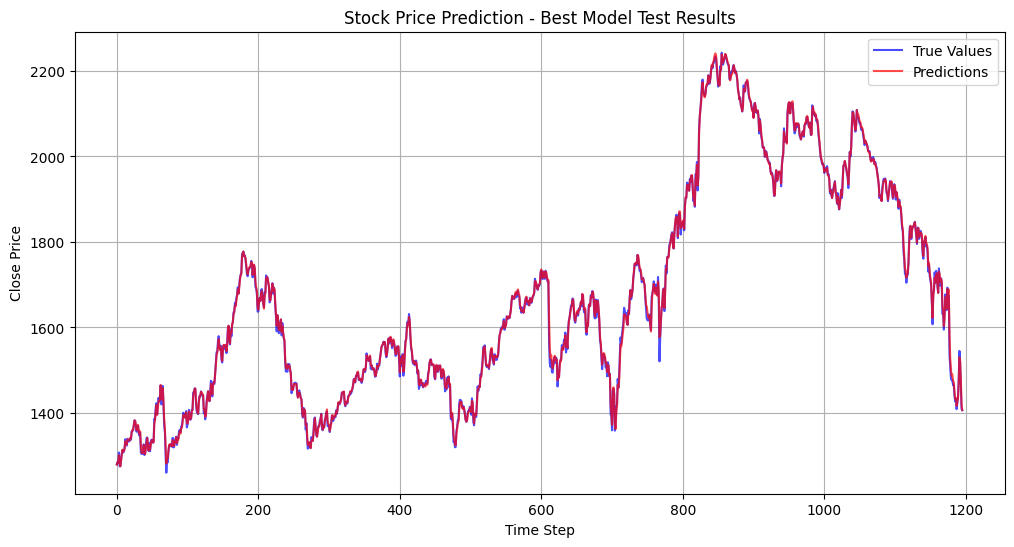

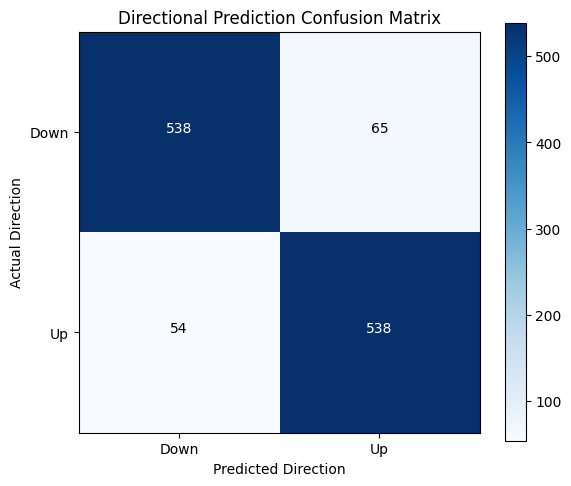

(array([1279.31342823, 1284.76945568, 1284.33312685, ..., 1475.89816145,
        1419.7827466 , 1406.80234735]),
 array([1280.27201928, 1285.03597859, 1282.71898816, ..., 1463.94201346,
        1409.6820026 , 1406.37100295]),
 {'mse': 37.96257207006315,
  'mae': 4.174293996397591,
  'r2': 0.9994114322302994,
  'direction_accuracy': 0.900418410041841,
  'classification': {'accuracy': 0.900418410041841,
   'precision': 0.8922056384742952,
   'recall': 0.9087837837837838,
   'f1': 0.900418410041841,
   'roc_auc': 0.9691743982788759},
  'confusion_matrix': [[538, 65], [54, 538]]})

In [24]:
def load_best_artifacts(manifest_path: str = './model/best_paths.json') -> tuple[str, str, dict]:
    manifest_path = os.path.normpath(manifest_path)
    if not os.path.exists(manifest_path):
        raise FileNotFoundError(f'未找到清单文件: {manifest_path}')
    with open(manifest_path, 'r', encoding='utf-8') as fh:
        manifest = json.load(fh)
    model_path = manifest.get('model_path')
    data_params_path = manifest.get('data_params_path')
    if not model_path or not data_params_path:
        raise KeyError('best_paths.json 缺少 model_path 或 data_params_path 字段。')
    def _resolve(candidate: str) -> str:
        return candidate if os.path.isabs(candidate) else os.path.abspath(candidate)
    model_path = _resolve(model_path)
    data_params_path = _resolve(data_params_path)

    if not os.path.exists(model_path):
        raise FileNotFoundError(f'最佳模型文件不存在: {model_path}')
    if not os.path.exists(data_params_path):
        raise FileNotFoundError(f'最佳数据参数文件不存在: {data_params_path}')

    manifest.setdefault('timestamp', time.strftime('%Y-%m-%d %H:%M:%S'))
    manifest['model_path'] = model_path
    manifest['data_params_path'] = data_params_path

    best_meta = manifest.get('best_params') or {}
    if best_meta:
        globals()['best_params'] = best_meta
    globals()['best_model_path'] = model_path
    globals()['best_data_path'] = data_params_path
    
    return model_path, data_params_path, manifest

best_model_path, best_data_path, best_manifest = load_best_artifacts()
print('🚀 已载入最佳模型配置:')
print(f"  模型路径: {best_model_path}")
print(f"  数据参数路径: {best_data_path}")
print(f"  训练时间戳: {best_manifest.get('timestamp', '未知')}")

eval(best_model_path, best_data_path)

In [27]:
# 绘制最佳模型的损失曲线并展示模型路径
best_model_path_value = globals().get('best_model_path')
if (
    'best_train_losses' in globals()
    and 'best_val_losses' in globals()
    and isinstance(best_train_losses, (list, tuple))
    and isinstance(best_val_losses, (list, tuple))
    and len(best_train_losses) > 0
    and len(best_val_losses) > 0
):
    plt.figure(figsize=(12, 6))
    plt.plot(best_train_losses, 'b-', label='Best Model Training Loss')
    plt.plot(best_val_losses, 'r-', label='Best Model Validation Loss')

    best_val_epoch = int(np.argmin(best_val_losses))
    plt.axvline(x=best_val_epoch, color='g', linestyle='--', label=f'Best Val Epoch: {best_val_epoch + 1}')
    plt.scatter(
        best_val_epoch,
        best_val_losses[best_val_epoch],
        color='green',
        s=100,
        zorder=5,
        label=f'Best Val Loss: {best_val_losses[best_val_epoch]:.6f}'
    )

    epoch_suffix = ''
    if 'best_final_epoch' in globals() and best_final_epoch is not None:
        epoch_suffix = f" (Stopped at Epoch {best_final_epoch})"

    plt.title(f'Best Model Loss Curve{epoch_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print('未能找到最佳模型的损失历史记录，无法绘制图像。')

if best_model_path_value:
    print(f'最佳模型路径: {best_model_path_value}')
else:
    print('未找到最佳模型路径，无法展示。')

未能找到最佳模型的损失历史记录，无法绘制图像。
最佳模型路径: d:\学习资料\25 04 神经网络模型对上证指数预测项目\lstm_torch_ver2\model\stock_hs256_nl1_do02_lr0.001_bs64.pkl
